In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from group_lasso import GroupLasso
from sklearn.pipeline import make_pipeline

## Gerando a base

In [3]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from group_lasso import GroupLasso
from sklearn.pipeline import make_pipeline

In [4]:
# =========================================
# 1. Gerando variáveis quantitativas
# =========================================
np.random.seed(42)
n_samples = 2000

X1 = np.random.normal(0, 1, n_samples)
X2 = np.random.normal(5, 2, n_samples)
X3 = np.random.uniform(-2, 2, n_samples)
X4 = np.random.chisquare(df=3, size=n_samples)

X_quant = np.column_stack([X1, X2, X3, X4])

# =========================================
# 2. Variável qualitativa com 4 categorias
# =========================================
categories = ['A', 'B', 'C', 'D']
X_cat = np.random.choice(categories, size=n_samples).reshape(-1, 1)

# One-hot encoding com drop da referência 'A'
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat_encoded = encoder.fit_transform(X_cat)

# =========================================
# 3. Dataset final como NumPy array
# =========================================
X = np.hstack([X_quant, X_cat_encoded])

# =========================================
# 4. Coeficientes verdadeiros
# =========================================
true_beta = np.array([1.5, 0, -2.0, 0,  # X1, X2, X3, X4
                      0, 2.5, 4.0])     # X_cat_B, X_cat_C, X_cat_D

# Gerando y
y = X @ true_beta + np.random.normal(0, 1.0, size=n_samples)

## Definindo os grupos de variaveis

In [5]:
# =========================================
# 5. Definindo os grupos
# =========================================
# Cada variável quantitativa em grupo separado, dummies em grupo único
groups = [0, 1, 2, 3, 4, 4, 4]

## Treinando o modelo inicial e verificando os coeficientes

In [6]:
# =========================================
# 6. Criando e treinando o modelo
# =========================================
scaler = StandardScaler()
group_lasso = GroupLasso(
    groups=np.array(groups),
    group_reg=0.1,
    l1_reg=0.0,
    scale_reg='group_size',
    supress_warning=True,
    n_iter=1000,
    tol=1e-3,
    fit_intercept=True
)

pipeline = make_pipeline(scaler, group_lasso)
pipeline.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('grouplasso',
                 GroupLasso(group_reg=0.1, groups=array([0, 1, 2, 3, 4, 4, 4]),
                            l1_reg=0.0, n_iter=1000, supress_warning=True,
                            tol=0.001))])

In [7]:
# =========================================
# 7. Resultados
# =========================================
coef_ = group_lasso.coef_.ravel()  # Correção aqui!
intercept = group_lasso.intercept_
feature_names = ['X1', 'X2', 'X3', 'X4', 'X_cat_B', 'X_cat_C', 'X_cat_D']

# Mostrando resultados
print("Intercepto:", intercept)
print("\nCoeficientes estimados pelo Group Lasso:")
for name, coef in zip(feature_names, coef_):
    print(f"{name}: {coef:.4f}")

Intercepto: [1.70632171]

Coeficientes estimados pelo Group Lasso:
X1: 1.2708
X2: -0.0000
X3: -2.1262
X4: 0.0000
X_cat_B: -0.2780
X_cat_C: 0.6738
X_cat_D: 1.1467


## Otimizando o hiperparâmetro



In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [18]:
# =========================================
# 8. Separando treino e teste
# =========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# =========================================
# 9. Validação cruzada para otimizar group_reg
# =========================================
reg_grid = np.logspace(-2, 1, 20)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

print("-" * 40)

for reg in reg_grid:
    fold_maes = []
    fold_r2s = []

    for train_idx, val_idx in kf.split(X_train):
        X_t, X_val = X_train[train_idx], X_train[val_idx]
        y_t, y_val = y_train[train_idx], y_train[val_idx]

        model = make_pipeline(
            StandardScaler(),
            GroupLasso(
                groups=groups,
                group_reg=reg,
                l1_reg=0,
                scale_reg='group_size',
                supress_warning=True,
                n_iter=1000,
                tol=1e-3,
                fit_intercept=True
            )
        )

        model.fit(X_t, y_t)
        y_pred = model.predict(X_val)
        fold_maes.append(mean_absolute_error(y_val, y_pred))
        fold_r2s.append(r2_score(y_val, y_pred))

    mean_mae = np.mean(fold_maes)
    mean_r2 = np.mean(fold_r2s)

    cv_results.append({
        'group_reg': reg,
        'mean_mae': mean_mae,
        'mean_r2': mean_r2
    })

    print(f"group_reg = {reg:.4f} | MAE médio: {mean_mae:.4f} | R² médio: {mean_r2:.4f}")

----------------------------------------
group_reg = 0.0100 | MAE médio: 0.7894 | R² médio: 0.9152
group_reg = 0.0144 | MAE médio: 0.7915 | R² médio: 0.9149
group_reg = 0.0207 | MAE médio: 0.7955 | R² médio: 0.9142
group_reg = 0.0298 | MAE médio: 0.8035 | R² médio: 0.9128
group_reg = 0.0428 | MAE médio: 0.8177 | R² médio: 0.9102
group_reg = 0.0616 | MAE médio: 0.8381 | R² médio: 0.9058
group_reg = 0.0886 | MAE médio: 0.8856 | R² médio: 0.8954
group_reg = 0.1274 | MAE médio: 0.9631 | R² médio: 0.8772
group_reg = 0.1833 | MAE médio: 1.0930 | R² médio: 0.8435
group_reg = 0.2637 | MAE médio: 1.2965 | R² médio: 0.7821
group_reg = 0.3793 | MAE médio: 1.6224 | R² médio: 0.6645
group_reg = 0.5456 | MAE médio: 2.0274 | R² médio: 0.4759
group_reg = 0.7848 | MAE médio: 2.3515 | R² médio: 0.2749
group_reg = 1.1288 | MAE médio: 2.7053 | R² médio: 0.0497
group_reg = 1.6238 | MAE médio: 2.7857 | R² médio: -0.0053
group_reg = 2.3357 | MAE médio: 2.7854 | R² médio: -0.0051
group_reg = 3.3598 | MAE médi

In [20]:
# =========================================
# 10. Melhor modelo
# =========================================
best_result = min(cv_results, key=lambda x: x['mean_mae'])
best_reg = best_result['group_reg']

print("\n Melhor group_reg encontrado:", round(best_reg, 4))

# =========================================
# 11. Treinamento final
# =========================================
final_model = make_pipeline(
    StandardScaler(),
    GroupLasso(
        groups=groups,
        group_reg=best_reg,
        l1_reg=0,
        scale_reg='group_size',
        supress_warning=True,
        n_iter=1000,
        tol=1e-3,
        fit_intercept=True
    )
)
final_model.fit(X_train, y_train)


 Melhor group_reg encontrado: 0.01


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('grouplasso',
                 GroupLasso(group_reg=0.01, groups=[0, 1, 2, 3, 4, 4, 4],
                            l1_reg=0, n_iter=1000, supress_warning=True,
                            tol=0.001))])

In [21]:
# =========================================
# 12. Avaliação no conjunto de teste
# =========================================
y_pred_test = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred_test)
final_r2 = r2_score(y_test, y_pred_test)

print(f"\n Desempenho no conjunto de teste:")
print(f"MAE: {final_mae:.4f}")
print(f"R²: {final_r2:.4f}")

# =========================================
# 13. Coeficientes finais
# =========================================
grouplasso_step = final_model.named_steps['grouplasso']
coef = grouplasso_step.coef_.ravel()
intercept = grouplasso_step.intercept_

print("\n Coeficientes do modelo final:")
for name, value in zip(feature_names, coef):
    print(f"{name}: {value:.4f}")


 Desempenho no conjunto de teste:
MAE: 0.7853
R²: 0.9113

 Coeficientes do modelo final:
X1: 1.4412
X2: -0.0000
X3: -2.3247
X4: -0.0000
X_cat_B: -0.0686
X_cat_C: 1.0595
X_cat_D: 1.5997


In [24]:
## Variaveis que foram selecionadas pelo modelo
non_zero_coefs = [name for name, value in zip(feature_names, coef) if np.abs(value) > 1e-5]
print("\nVariáveis selecionadas pelo modelo (coef ≠ 0):", non_zero_coefs)


Variáveis selecionadas pelo modelo (coef ≠ 0): ['X1', 'X3', 'X_cat_B', 'X_cat_C', 'X_cat_D']


## Visualizacao do erro vs hiperparametro

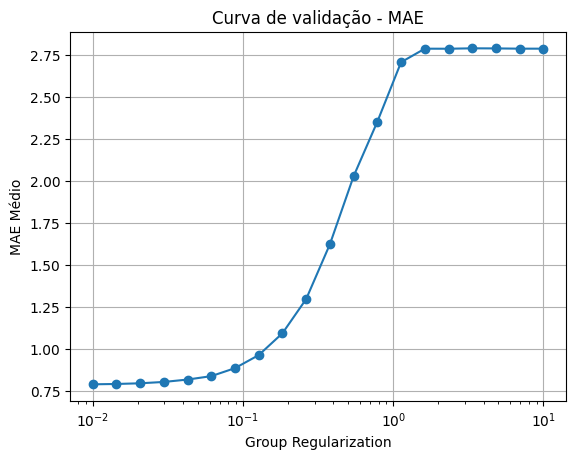

In [22]:
import matplotlib.pyplot as plt

regs = [res['group_reg'] for res in cv_results]
maes = [res['mean_mae'] for res in cv_results]
r2s = [res['mean_r2'] for res in cv_results]

plt.figure()
plt.plot(regs, maes, marker='o')
plt.xscale('log')
plt.xlabel('Group Regularization')
plt.ylabel('MAE Médio')
plt.title('Curva de validação - MAE')
plt.grid(True)
plt.show()